## Data Preparation

### Packages and Libraries

In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from  sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix


import warnings
warnings.filterwarnings("ignore")

### Data Loading and Preprocessing

In [21]:
data = pd.read_csv("https://raw.githubusercontent.com/mansi-guptaa/E-Commerce-Recommendation-System/refs/heads/main/marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv",sep = "\t")


In [22]:
data.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

### Selecting Important Columns

In [23]:
new_data = data[['Uniq Id', 'Product Id', 'Product Category', 'Product Brand', 'Product Name', 'Product Description', 'Product Image Url', 'Product Tags',
                  'Product Rating', 'Product Reviews Count']]

In [24]:
new_data.head(2)

,Uniq Id,Product Id,Product Category,Product Brand,Product Name,Product Description,Product Image Url,Product Tags,Product Rating,Product Reviews Count
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",NaN,NaN
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",Pack of 3 Pack of 3 for the UPC: 381519000201 ...,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"Nice 'n Easy Permanent Color, 111 Natural Medi...",NaN,NaN


### Shape of Data

In [25]:
new_data.shape

(5000, 10)

### Handling Null Values

In [26]:
new_data.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Category           10
Product Brand              13
Product Name                0
Product Description      1127
Product Image Url           0
Product Tags                0
Product Rating           2806
Product Reviews Count    1654
dtype: int64

In [27]:
new_data['Product Category'] = new_data['Product Category'].fillna(" ")
new_data['Product Brand'] =new_data['Product Brand'].fillna(" ")
new_data['Product Description'] = new_data['Product Description'].fillna(" ")
new_data['Product Reviews Count'] = new_data['Product Reviews Count'].fillna(0)
new_data['Product Rating'] = new_data['Product Rating'].fillna(0)

In [28]:
new_data.isnull().sum()

Uniq Id                  0
Product Id               0
Product Category         0
Product Brand            0
Product Name             0
Product Description      0
Product Image Url        0
Product Tags             0
Product Rating           0
Product Reviews Count    0
dtype: int64

### Renaming Columns

In [29]:
columns_name_mapping = {'Uniq Id':'ID', 'Product Id':'ProdID', 'Product Category':'Category', 'Product Brand':'Brand',
       'Product Name':'Name', 'Product Description':'Description', 'Product Image Url':'ImageUrl',
       'Product Tags':'Tags', 'Product Rating':'Rating', 'Product Reviews Count':'ReviewsCount'}

new_data.rename(columns = columns_name_mapping, inplace = True)

### Transforming Columns

In [30]:
new_data['ID'] = new_data['ID'].str.extract(r'(\d+)').astype(float)
new_data['ProdID'] = new_data['ProdID'].str.extract(r'(\d+)').astype(float)

In [31]:
new_data.head(3)

,ID,ProdID,Category,Brand,Name,Description,ImageUrl,Tags,Rating,ReviewsCount
0,1.705737e+09,2.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",0.0,0.0
1,9.500000e+01,76.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",Pack of 3 Pack of 3 for the UPC: 381519000201 ...,https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"Nice 'n Easy Permanent Color, 111 Natural Medi...",0.0,0.0
2,8.000000e+00,8.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,This Clairol Nice N Easy Permanent Color gives...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,Clairol Nice 'N Easy Permanent Color 7/106A Na...,4.5,29221.0


### EDA

In [32]:
num_users = new_data['ID'].nunique()
num_items = new_data['ProdID'].nunique()
num_rating = new_data['Rating'].nunique()
print("Unique users : ", num_users)
print("Unique Products : ", num_items)
print("Unique Ratings : ", num_rating)

Unique users :  1721
Unique Products :  1697
Unique Ratings :  36


Text(0.5, 1.0, 'Most popular Items')

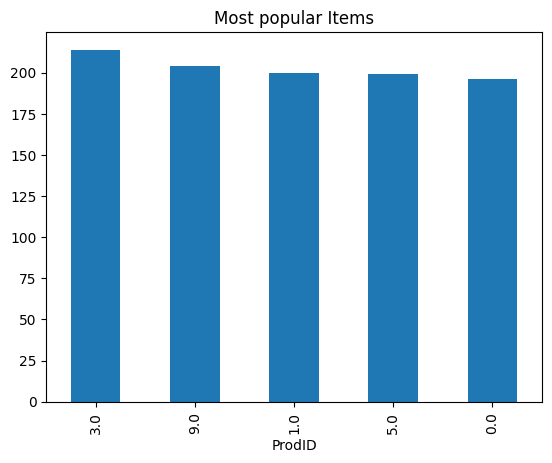

In [33]:
popular_items = new_data['ProdID'].value_counts().head(5)
popular_items.plot(kind = 'bar')
plt.title("Most popular Items")

Text(0.5, 1.0, 'Most popular Brand')

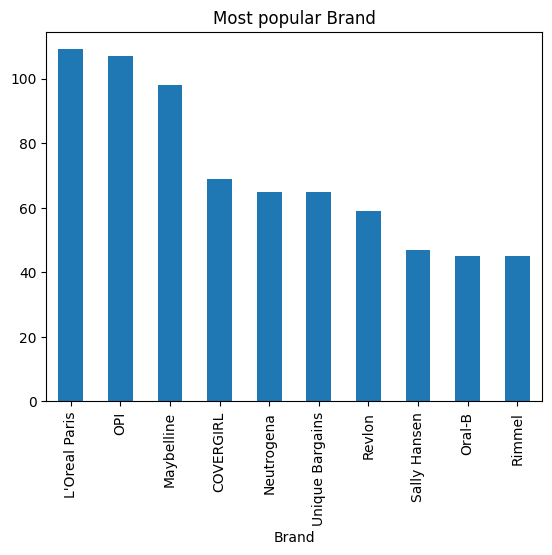

In [34]:
popular_brand = new_data['Brand'].value_counts().head(10)
popular_brand.plot(kind = 'bar')
plt.title("Most popular Brand")

In [35]:
# Count occurrences of each combination of 'Rating' and 'ProdID'
top_rated_products = (
    new_data[['Rating', 'ProdID']]
    .value_counts()
    .reset_index(name='Count')  # Convert to DataFrame and name the count column
    .sort_values(by=['Rating', 'Count'], ascending=[False, False])  # Sort by Rating, then Count
    .head(5)  # Get the top 5
)

top_rated_products


,Rating,ProdID,Count
10,5.0,3.0,25
11,5.0,2.0,23
12,5.0,0.0,23
13,5.0,9.0,22
14,5.0,7.0,20


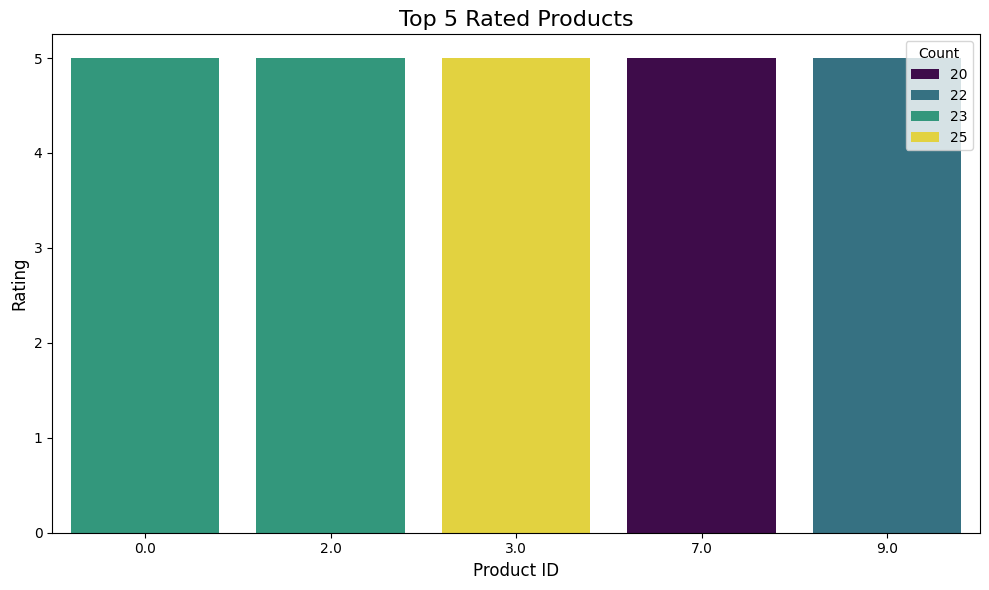

In [36]:
# Bar plot for top-rated products
plt.figure(figsize=(10, 6))
sns.barplot(
    x='ProdID',
    y='Rating',
    data=top_rated_products,
    hue='Count',
    palette='viridis'
)

# Customizing the plot
plt.title('Top 5 Rated Products', fontsize=16)
plt.xlabel('Product ID', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.legend(title='Count', loc='upper right')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


### Data Cleaning And Tags Creation

In [37]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_extract_tags(text):
  doc = nlp(text.lower())
  tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
  return ",".join(tags)

columns_to_extarct_tags_from = ['Category', 'Brand','Description']

for column in columns_to_extarct_tags_from:
  new_data[column] = new_data[column].apply(clean_extract_tags)

In [38]:
new_data['Tags'] = new_data[columns_to_extarct_tags_from].apply(lambda row: ",".join(row), axis = 1)

In [39]:
new_data.head()

,ID,ProdID,Category,Brand,Name,Description,ImageUrl,Tags,Rating,ReviewsCount
0,1.705737e+09,2.0,"premium,beauty,premium,makeup,premium,nail,pol...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",,https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,"premium,beauty,premium,makeup,premium,nail,pol...",0.0,0.0
1,9.500000e+01,76.0,"beauty,hair,care,hair,color,auburn,hair,color",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...","pack,3,pack,3,upc,381519000201,beautiful,natur...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"beauty,hair,care,hair,color,auburn,hair,color,...",0.0,0.0
2,8.000000e+00,8.0,"beauty,hair,care,hair,color,permanent,hair,color",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,"clairol,nice,n,easy,permanent,color,gives,8,we...",https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"beauty,hair,care,hair,color,permanent,hair,col...",4.5,29221.0
3,4.000000e+00,3.0,"beauty,makeup,lip","kokie,cosmetics","Kokie Professional Matte Lipstick, Hot Berry, ...","calling,matte,lip,lovers,indulge,rich,creamy,m...",https://i5.walmartimages.com/asr/25b4b467-bc61...,"beauty,makeup,lip,kokie,cosmetics,calling,matt...",0.0,0.0
4,9.900000e+02,3.0,"seasonal,stock,essentials,personal,care,stock,...",gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...","1971,gillette,introduced,trac,ii,razor,system,...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"seasonal,stock,essentials,personal,care,stock,...",0.0,131.0


## Rating Base Recommendation System

In [40]:
average_rating = new_data.groupby(['Name','ReviewsCount', 'Brand', 'ImageUrl'])['Rating'].mean().reset_index()
top_rated_items = average_rating.sort_values(by= 'Rating', ascending = False)

rating_base_recommmendations = top_rated_items.head(10)

In [41]:
rating_base_recommmendations['ReviewsCount'] = rating_base_recommmendations['ReviewsCount'].astype(int)
rating_base_recommmendations['Rating'] = rating_base_recommmendations['Rating'].astype(int)

In [42]:
print("Rating Base Rcommendation System : (Trending Products)")
rating_base_recommmendations

Rating Base Rcommendation System : (Trending Products)


,Name,ReviewsCount,Brand,ImageUrl,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1,"peter,thomas,roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10,"burt,bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5
1208,Clairol Professional Beautiful Collection Semi...,1,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13,"clay,park,labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5
4857,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5
4862,ZINSSER & CO Jomax 1-Qt. Mold & Mildew Stain R...,1,jomax,https://i5.walmartimages.com/asr/d04c8d61-023a...,5
4892,"all Free Clear For Sensitive Skin, 110 Loads, ...",4,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5
33,($55 Value) Clarins Multi-Active Day Face Crea...,2,clarins,https://i5.walmartimages.com/asr/894b62ab-76d2...,5


## Content Base Recommendation System(User Prefrence and Item Similarities)

In [43]:
def content_base_recommendation_system(new_data, item_name, top_n = 10):
  if item_name not in new_data['Name'].values:
    print(f'Item {item_name} not found in the database')
    return pd.DataFrame()

  tfidf_vectorizer = TfidfVectorizer(stop_words = 'english')
  tfidf_matrix_content = tfidf_vectorizer.fit_transform( new_data['Tags'])
  cosine_similarity_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

  item_index = new_data[new_data['Name'] == item_name].index[0]
  similar_item = list(enumerate(cosine_similarity_content[item_index]))
  sorted_similar_item = sorted(similar_item, key = lambda x: x[1], reverse = True)
  top_similar_item = sorted_similar_item[:top_n]
  recommended_similar_index = [x[0] for x in top_similar_item]
  recommended_item_details = new_data.iloc[recommended_similar_index][['Name','ReviewsCount', 'Brand', 'ImageUrl','Rating']]

  return recommended_item_details



In [44]:
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_recommendation = content_base_recommendation_system(new_data, item_name, top_n = 8)
content_based_recommendation

,Name,ReviewsCount,Brand,ImageUrl,Rating
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4


## Collaborative Filtering Recommendation System(User item Similarity)

In [45]:
def Collaborative_Filtering_Recommendation_System(new_data, target_user_id, top_n = 10):
  user_item_matrix = new_data.pivot_table(index = 'ID', columns = 'ProdID', values = 'Rating', aggfunc = 'mean').fillna(0).astype(int)
  user_similarity = cosine_similarity(user_item_matrix)

  target_user_index = user_item_matrix.index.get_loc(target_user_id)
  target_user_similarity = user_similarity[target_user_index]
  similar_user_index = target_user_similarity.argsort()[::-1][1:]

  recommended_items = []
  for user_index in similar_user_index:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

    recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

  recommended_item_details = new_data[new_data['ProdID'].isin(recommended_items)][['Name', 'ReviewsCount', 'Brand','ImageUrl','Rating']]

  return recommended_item_details


In [46]:
target_user_id=4
top_n = 5
Collaborative_Filtering_Recommendation = Collaborative_Filtering_Recommendation_System(new_data, target_user_id).head(5)
print(f'Top {top_n} recommendations for user_id {target_user_id}:')
Collaborative_Filtering_Recommendation

Top 5 recommendations for user_id 4:


,Name,ReviewsCount,Brand,ImageUrl,Rating
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
61,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3
64,Neutrogena SkinClearing Oil-Free Liquid Founda...,741.0,neutrogena,https://i5.walmartimages.com/asr/fd4d78d8-310a...,4.2
69,Design Essentials Natural Coconut & Monoi Curl...,1.0,"design,essentials",https://i5.walmartimages.com/asr/ff2dba1d-0c02...,5.0


## Hybrid Recommendation System

In [47]:
def hybrid_recommendation_system(new_data, target_user_id, item_name, top_n = 10):
  content_base_rec = content_base_recommendation_system(new_data, item_name, top_n = 10)
  collaborative_base_rec = Collaborative_Filtering_Recommendation_System(new_data, target_user_id, top_n = 10)

  hybrid_base_rec = pd.concat([content_base_rec,collaborative_base_rec]).drop_duplicates()

  return hybrid_base_rec.head(10)


In [48]:
target_user_id = 4
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
hybrid_recommendations = hybrid_recommendation_system(new_data, target_user_id, item_name, top_n = 10)

print(f'Top 10 Hybrid Recommendation System are:')
hybrid_recommendations

Top 10 Hybrid Recommendation System are:


,Name,ReviewsCount,Brand,ImageUrl,Rating
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
3406,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
546,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
2406,"L.A. Colors Matte Lipstick, Tender Matte",3.0,colors,https://i5.walmartimages.com/asr/271264fb-e8c3...,3.7
4050,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
4084,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1559,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2873,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie,cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3023,Be Matte Lipstick - Pink,2.0,"city,color",https://i5.walmartimages.com/asr/4425a13e-085f...,3.0
4541,Be Matte Lipstick - Soft Pink,2.0,"city,color",https://i5.walmartimages.com/asr/69e1ec63-be5e...,3.0
